# Creating Binary Cassification NN Model

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from keras_tuner import RandomSearch
import pandas as pd
from matplotlib import pyplot as plt
from ann_visualizer.visualize import ann_viz 
import numpy as np

### Split the Train/Test set (80% Train (40% tune, 40% train), 20% Test)

In [2]:
# Load dataset
df = pd.read_csv("../datasets/binarydataset.csv",index_col=0)

In [7]:
X = df.iloc[:, 3:]  # Returns Features
Y = df.iloc[:, 2]  # Returns Calls
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=True, random_state=32)

### Create Binary Classification Model (Sequential)
Layers:
1. Flatten 18 features to input data
2. Hidden layer between 20 - 320 neurons w/ ReLu activation  
3. Output layer w/ Sigmoid activation

Hyperparameters being tuned
1. Amount of neurons in first layer w/ 40 steps 
2. Learning Rate [1e-1, le-4]

In [8]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(19,)))  # Input Layer (18=features)
    model.add(Dense(units=hp.Int("units", min_value=20, max_value=320, step=40),
              activation="relu", name="Hidden_layer1"))  # Find best amount of neurons for layer
    model.add(Dense(1, activation="sigmoid", name="Output_layer"))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[
                  1e-2, 1e-4])), loss='binary_crossentropy', metrics=["accuracy"])  # Adam = SGD
    return model

## Create deep neural network model with 1-5 layers
NOTE: Not used within tuning/training since accuracy doesn't improve

In [9]:
def build_model_layerN(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(19,)))  # Input Layer (10=features)

    # Finds how many layers should be in NN
    for layer in range(hp.Int("num_layers", 1, 5)):
        model.add(Dense(units=hp.Int("units_" + str(layer), min_value=20, max_value=320,
                  step=40), activation="relu"))  # Find best amount of neurons for layer
    model.add(Dense(1, activation="sigmoid", name="output_layer"))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[
                  1e-2, 1e-4])), loss='binary_crossentropy', metrics=["accuracy"])  # Adam = SGD
    return model

### Find the best hyperparameters for TrainingSet using RandomSearch
How to determine max_trails and executions_per_trail https://medium.com/@avengers14.blogger/what-are-max-trials-and-executions-per-trial-in-keras-tuner-68ef9a18497d

In [10]:
# Stop training when loss doesn't imporve in 1 epoches
callback = EarlyStopping(monitor="loss", min_delta=.01, patience=5)
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    directory='binary_trails',  # Store results
    project_name='FirePredict',
    overwrite=True, 
    max_trials=32,  # Bc 16 steps x 2 learning_rates
    executions_per_trial=3  # How many times to train verison of model
)

In [11]:
tuner_n_layers = RandomSearch(
    build_model_layerN,
    objective='val_accuracy',
    directory='trails_directory_V2',  # Store results
    project_name='FirePredict',
    overwrite=True, # Delete Previous Trails Files
    max_trials=160,  # Bc 16 steps x 2 learning_rates x 5 potential layers
    executions_per_trial=3  # How many times to train verison of model
)
tuner.search(X_train, Y_train, callbacks=[callback], validation_split=.5)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
140               |?                 |units
0.01              |?                 |learning_rate



c:\Users\david\anaconda3\envs\ML\lib\site-packages\keras\engine\data_adapter.py:1506: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

## Obtain the best hyperparameters to be used within training of model

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# accuracy = train accuracy, val_accuracy = test accuracy
history = model.fit(X_train, Y_train, epochs=50, callbacks=[callback], validation_split=.5)

IndexError: list index out of range

# Stats about Neural Network Model

Training and Validation set accuracy

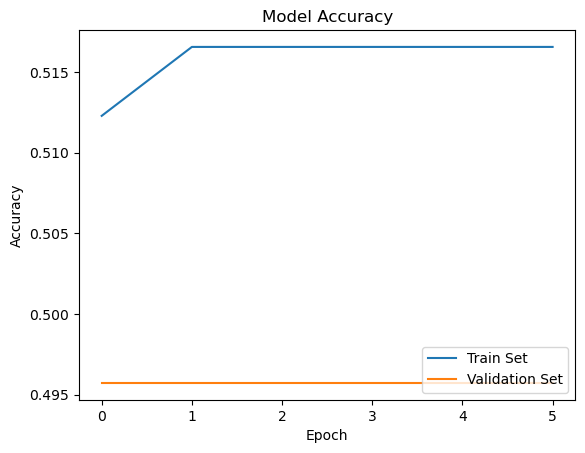

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 19)                0         
                                                                 
 Hidden_layer1 (Dense)       (None, 300)               6000      
                                                                 
 Output_layer (Dense)        (None, 1)                 301       
                                                                 
Total params: 6,301
Trainable params: 6,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train Set", "Validation Set"], loc="lower right")
plt.show()
model.summary()

Training and Validation Loss

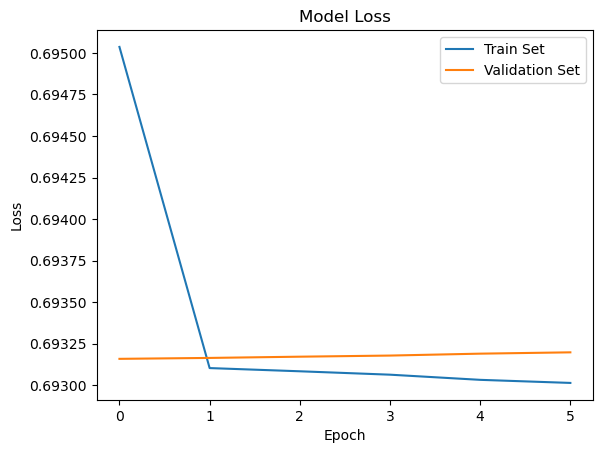

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Validation Set'], loc='upper right')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test,Y_test)

59/59 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5037
